# <center><font color='green'>PUBG Game Prediction</font><center>

<center><img src="https://media.giphy.com/media/XVbrX433vn6rqkexSj/giphy.gif"> </center>

## Table Content

1. [Importing the Libraries](#import)
2. [Reading Data](#read)
3. [Data Wrangling](#datawrang)

# Importing the Libraries <a class='anchor' id='import'></a>

In [10]:
# Standard Libraries 
import pandas as pd
import numpy as np

# Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(16,6)

import seaborn as sns

# Handling Warnings 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

!pip install catboost
import catboost as cb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading the Data <a class='anchor' id='read'></a>

In [2]:
data=pd.read_csv('PUBG_Game_Prediction_data.csv')

In [11]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Data Descritption

- <b>DBNOs -</b> Number of enemy players knocked.
- **assists -** Number of enemy players this player damaged that were killed by teammates.
- **boosts -** Number of boost items used.
- **damageDealt -** Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills -** Number of enemy players killed with headshots.
- **heals -** Number of healing items used.
- **Id -** Player’s Id
- **killPlace -** Ranking in match of number of enemy players killed.
- **killPoints -** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks -** Max number of enemy players killed in a short amount of time.
- **kills -** Number of enemy players killed.
- **longestKill -** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration -** Duration of match in seconds.
- **matchId -** ID to identify match. There are no matches that are in both the training and testing set.
- **matchType -** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints -** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives -** Number of times this player revived teammates.
- **rideDistance -** Total distance traveled in vehicles measured in meters.
- **roadKills -** Number of kills while in a vehicle.
- **swimDistance -** Total distance traveled by swimming measured in meters.
- **teamKills -** Number of times this player killed a teammate.
- **vehicleDestroys -** Number of vehicles destroyed.
- **walkDistance -** Total distance traveled on foot measured in meters.- 
- **weaponsAcquired -** Number of weapons picked up.
- **winPoints -** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- **groupId -** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups -** Number of groups we have data for in the match.
- **maxPlace -** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc -** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Wrangling <a class='anchor' id='datawrang'></a>

In [12]:
# Checking for the null values for winPlacePerc

data['winPlacePerc'].isnull().sum()


1

In [13]:
data[data['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [14]:
data.drop(2744604,inplace=True)

In [27]:
# prepare new parameter to know how many players are in a game
data['playersJoined'] = data.groupby('matchId')['matchId'].transform('count')

In [16]:
data['players'].head()

0    96
1    91
2    98
3    91
4    97
Name: players, dtype: int64

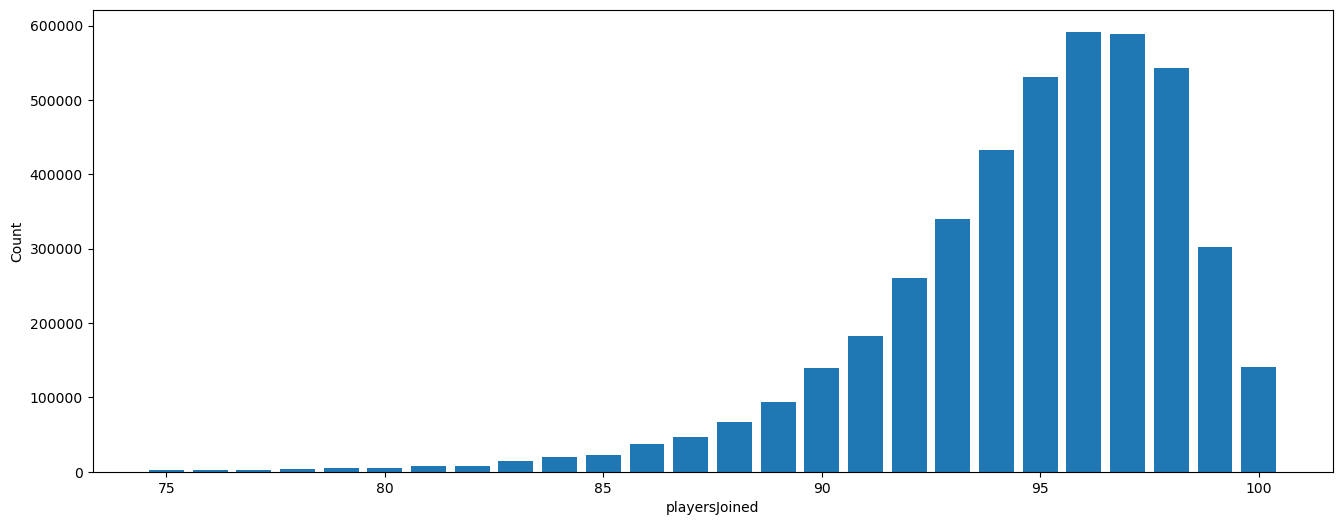

In [29]:
filtered_data = data[data['playersJoined'] >= 75]
players_joined_counts = filtered_data['playersJoined'].value_counts().reset_index()

plt.bar(players_joined_counts['index'], players_joined_counts['playersJoined'])
plt.xlabel('playersJoined')
plt.ylabel('Count')
plt.show()

## Analysis of the data

## Killing without moving

<center><img src = "https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif"></center>

In [31]:
data['total_distance']=data['rideDistance']+data['walkDistance']+data['swimDistance']

In [32]:
data['killsWithoutMoving']=((data['kills']>0) & (data['total_distance']==0))

In [33]:
data[data['killsWithoutMoving']==True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,players,playersJoined,total_distance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0,0,0.0,8,0,0.8571,58,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0,0,0.0,22,0,0.6000,42,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0,0,0.0,13,0,0.8947,21,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0,0,0.0,7,1500,0.0000,73,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0,0,0.0,10,0,0.3000,42,42,0.0,True


In [34]:
data[data['killsWithoutMoving']==True].shape

(1535, 33)

In [36]:
data.drop(data[data['killsWithoutMoving']==True].index,inplace=True)

## Extra Ordinary Road Kills

<center><img src = "https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif"></center>

In [38]:
data[data['roadKills']>5].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,players,playersJoined,total_distance,killsWithoutMoving
39338,0097d2ae7a8576,b61edfa0c228d4,a786011fe206e9,1,2,495.7,4,0,0,2,...,0,0,72.80,1,0,0.9362,92,92,5202.80,False
90312,0e6ea81fd1b9b3,1e96ac916d6fbb,3f150f3834422c,2,6,190.0,0,0,5,2,...,0,1,976.80,4,0,0.9556,89,89,4257.80,False
197752,6cf1efa197bcc1,28df010b29a9e2,2e40495266529f,0,2,800.0,5,0,4,1,...,0,0,1516.00,3,0,0.6538,89,89,10085.00,False
209676,5df28fce2b8128,32a01a5517635a,ee9fb50eb0fe00,0,3,360.0,2,0,4,1,...,0,0,36.96,0,0,1.0000,59,59,6142.96,False
213544,612ee3024560a3,ab0162b0300c59,7c5535bfd43592,1,2,426.3,3,0,0,1,...,0,0,128.30,3,0,0.9167,96,96,3607.30,False


In [39]:
data[data['roadKills']>5].shape

(46, 33)

In [40]:
data.drop(data[data['roadKills']>5].index,inplace=True)

## So many kills how ?????

<center><img src = "https://media.giphy.com/media/3oxHQfzBhpKtgdDWtW/giphy.gif"></center>

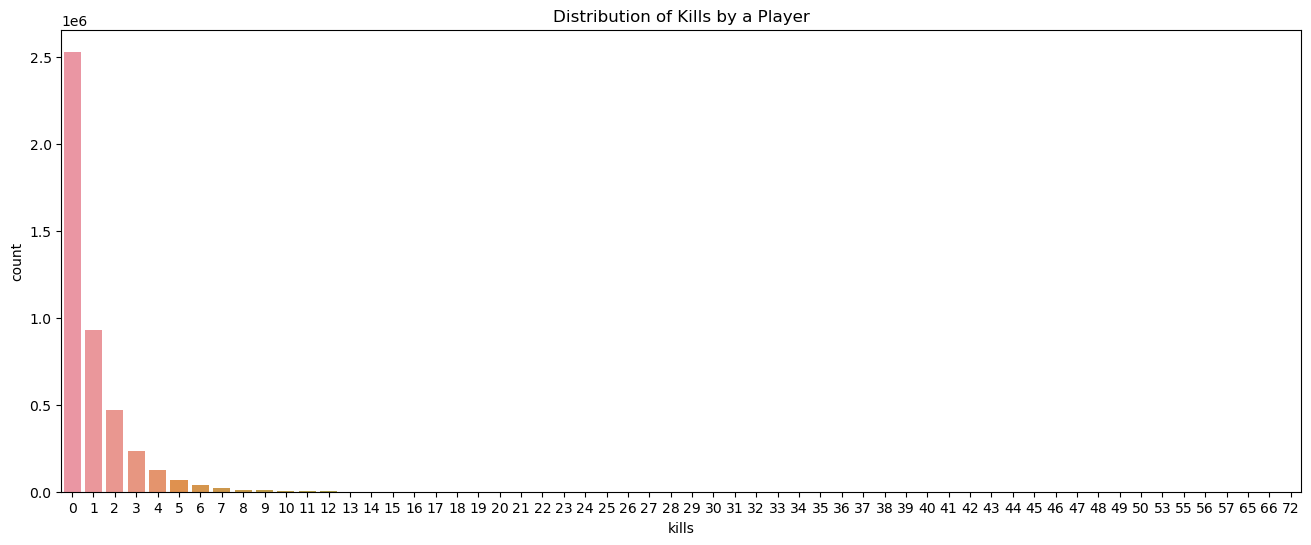

In [41]:
sns.countplot(x='kills',data=data).set_title('Distribution of Kills by a Player')
plt.show()

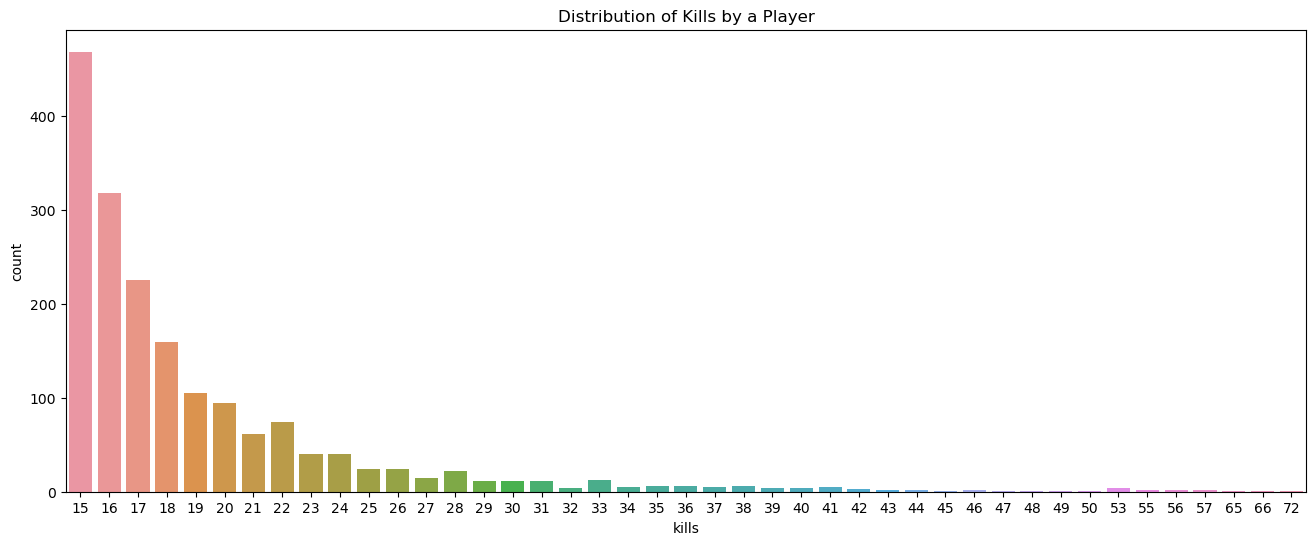

In [44]:
sns.countplot(x=data[data['kills']>=15]['kills'],data=data).set_title('Distribution of Kills by a Player')
plt.show()

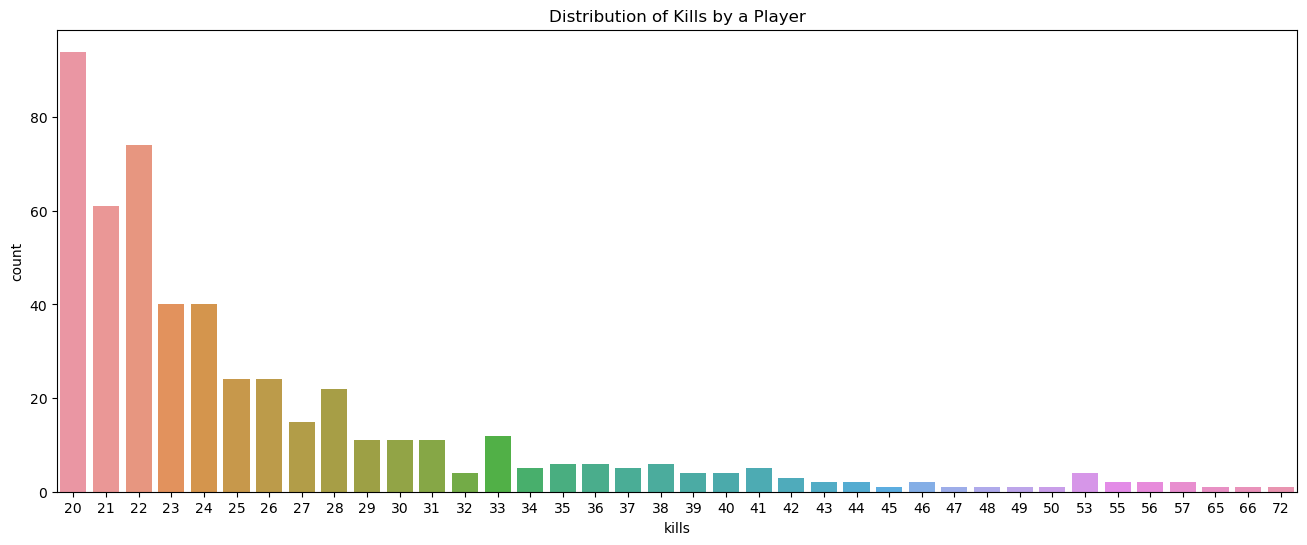

In [45]:
sns.countplot(x=data[data['kills']>=20]['kills'],data=data).set_title('Distribution of Kills by a Player')
plt.show()

In [46]:
data.drop(data[data['kills']>=20]['kills'].index,inplace=True)

## Head Shot

<center><img src = "https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif"></center>

In [47]:
data['head_shot_rate']=data['headshotKills']/data['kills']

In [51]:
data['head_shot_rate']=data['head_shot_rate'].fillna(0)

In [53]:
data['head_shot_rate'].unique()

array([0.        , 1.        , 0.25      , 0.5       , 0.22222222,
       0.4       , 0.2       , 0.75      , 0.33333333, 0.66666667,
       0.375     , 0.6       , 0.21428571, 0.07692308, 0.16666667,
       0.14285714, 0.42857143, 0.28571429, 0.08333333, 0.8       ,
       0.625     , 0.41666667, 0.36363636, 0.125     , 0.44444444,
       0.30769231, 0.27272727, 0.15384615, 0.3       , 0.23529412,
       0.11111111, 0.83333333, 0.71428571, 0.1       , 0.55555556,
       0.45454545, 0.23076923, 0.57142857, 0.18181818, 0.09090909,
       0.46153846, 0.29411765, 0.81818182, 0.875     , 0.06666667,
       0.85714286, 0.1875    , 0.38461538, 0.4375    , 0.35714286,
       0.7       , 0.07142857, 0.26315789, 0.72727273, 0.5625    ,
       0.15789474, 0.46666667, 0.53846154, 0.89473684, 0.26666667,
       0.54545455, 0.77777778, 0.10526316, 0.53333333, 0.27777778,
       0.63636364, 0.61538462, 0.58333333, 0.41176471, 0.13333333,
       0.88888889, 0.05882353, 0.21052632, 0.78571429, 0.6875 

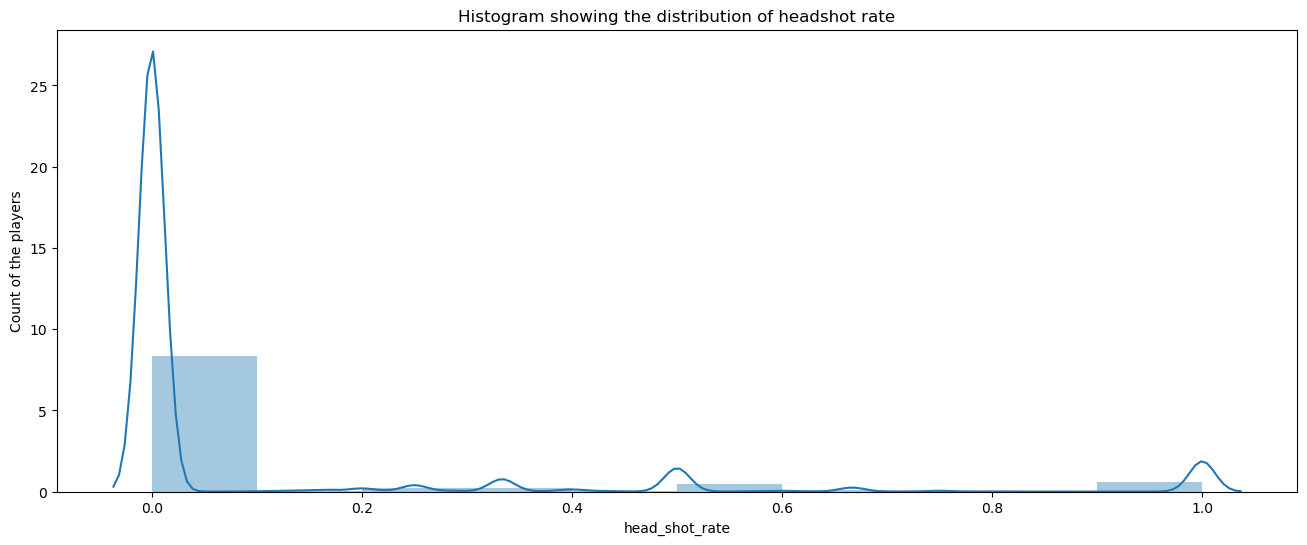

In [54]:
sns.distplot(data['head_shot_rate'],bins=10).set_title('Histogram showing the distribution of headshot rate')
plt.ylabel('Count of the players')
plt.show()

In [55]:
data[(data['head_shot_rate']==1) & (data['kills']>5)].shape

(187, 34)

In [56]:
data[(data['head_shot_rate']==1) & (data['kills']>5)].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,players,playersJoined,total_distance,killsWithoutMoving,head_shot_rate
43791,9afbe8ecaec518,19215cc89a51d7,0c70c2be6426f5,0,0,959.4,8,7,0,1,...,0,1823.0,4,0,0.5833,90,90,2824.0,False,1.0
45447,eb5516fd4df6fe,45c62861949040,6f46cd41d884d8,0,4,740.5,0,6,2,3,...,0,4403.0,4,0,0.9896,97,97,4403.0,False,1.0
66266,1a23298ecdb19d,d5d54b4be23079,e111ebb6185bc8,0,4,1469.0,9,8,0,2,...,0,2107.0,6,0,0.7200,94,94,4864.0,False,1.0
102499,d897450a550371,597f96e4f44ab8,afd45aeba13205,1,1,689.0,0,7,3,16,...,0,2421.0,12,1500,0.5806,32,32,4078.0,False,1.0
104571,cbebfd04b26842,90d0154538dfa3,b0a10671999dc9,0,4,1153.0,0,8,2,1,...,0,1898.0,4,1513,0.8780,83,83,3806.0,False,1.0


In [57]:
data.drop(data[(data['head_shot_rate']==1) & (data['kills']>5)].index,inplace=True)

## Longest Shot

<center><img src = "https://media.giphy.com/media/3ohs7YomxqOz4GRHcQ/giphy.gif"></center>

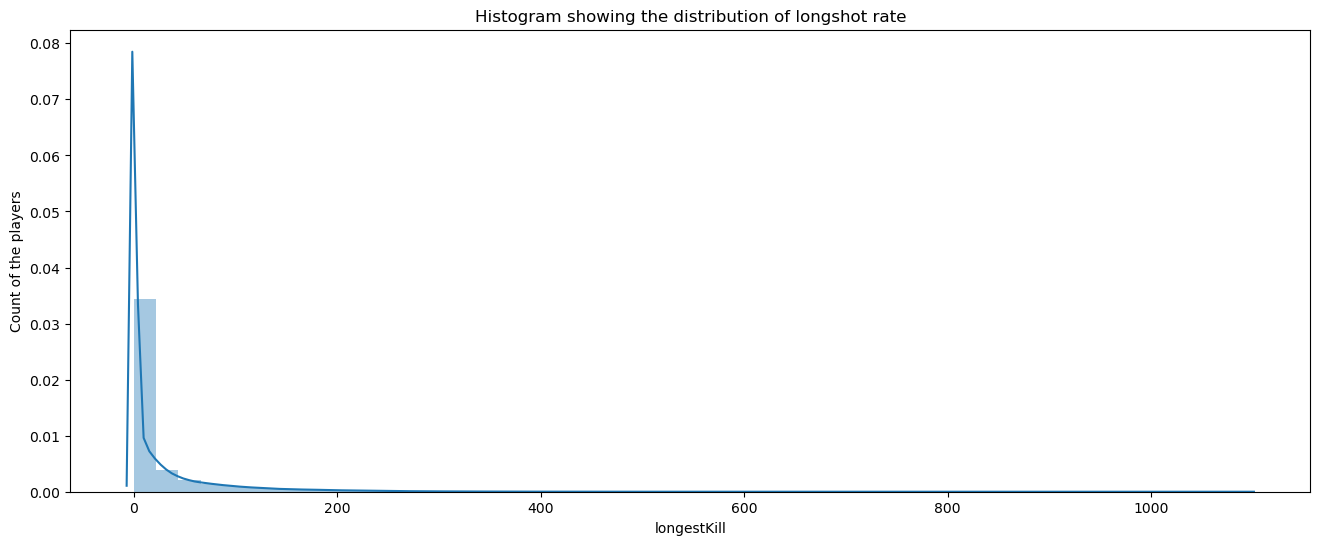

In [58]:
sns.distplot(data['longestKill'],bins=50).set_title('Histogram showing the distribution of longshot rate')
plt.ylabel('Count of the players')
plt.show()

In [60]:
data[data['longestKill']>=500].shape

(1735, 34)

In [61]:
data.drop(data[data['longestKill']>=500].index,inplace=True)

## Weapon Change

<center><img src = "https://j.gifs.com/3loOmn.gif"></center>

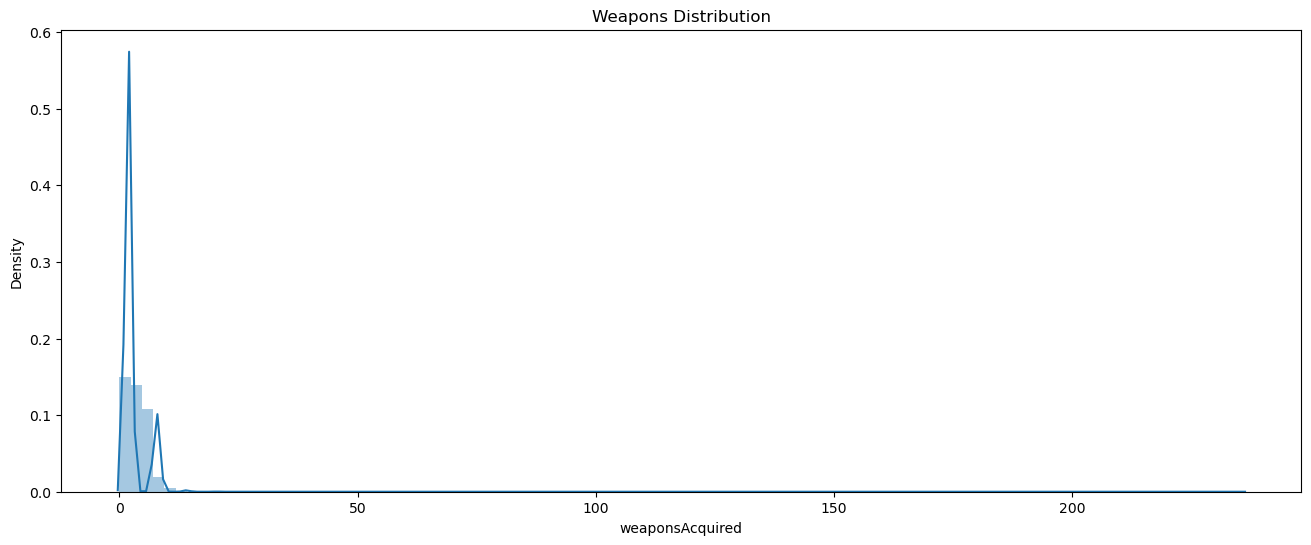

In [62]:
sns.distplot(data['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [63]:
data[data['weaponsAcquired']>=15].shape

(6755, 34)

In [64]:
data.drop(data[data['weaponsAcquired']>=15].index, inplace = True)

## EDA 

In [65]:
data.shape

(4436196, 34)

In [67]:
data.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
players               0
playersJoined         0
total_distance        0
killsWithoutMoving    0
head_shot_rate        0
dtype: int64

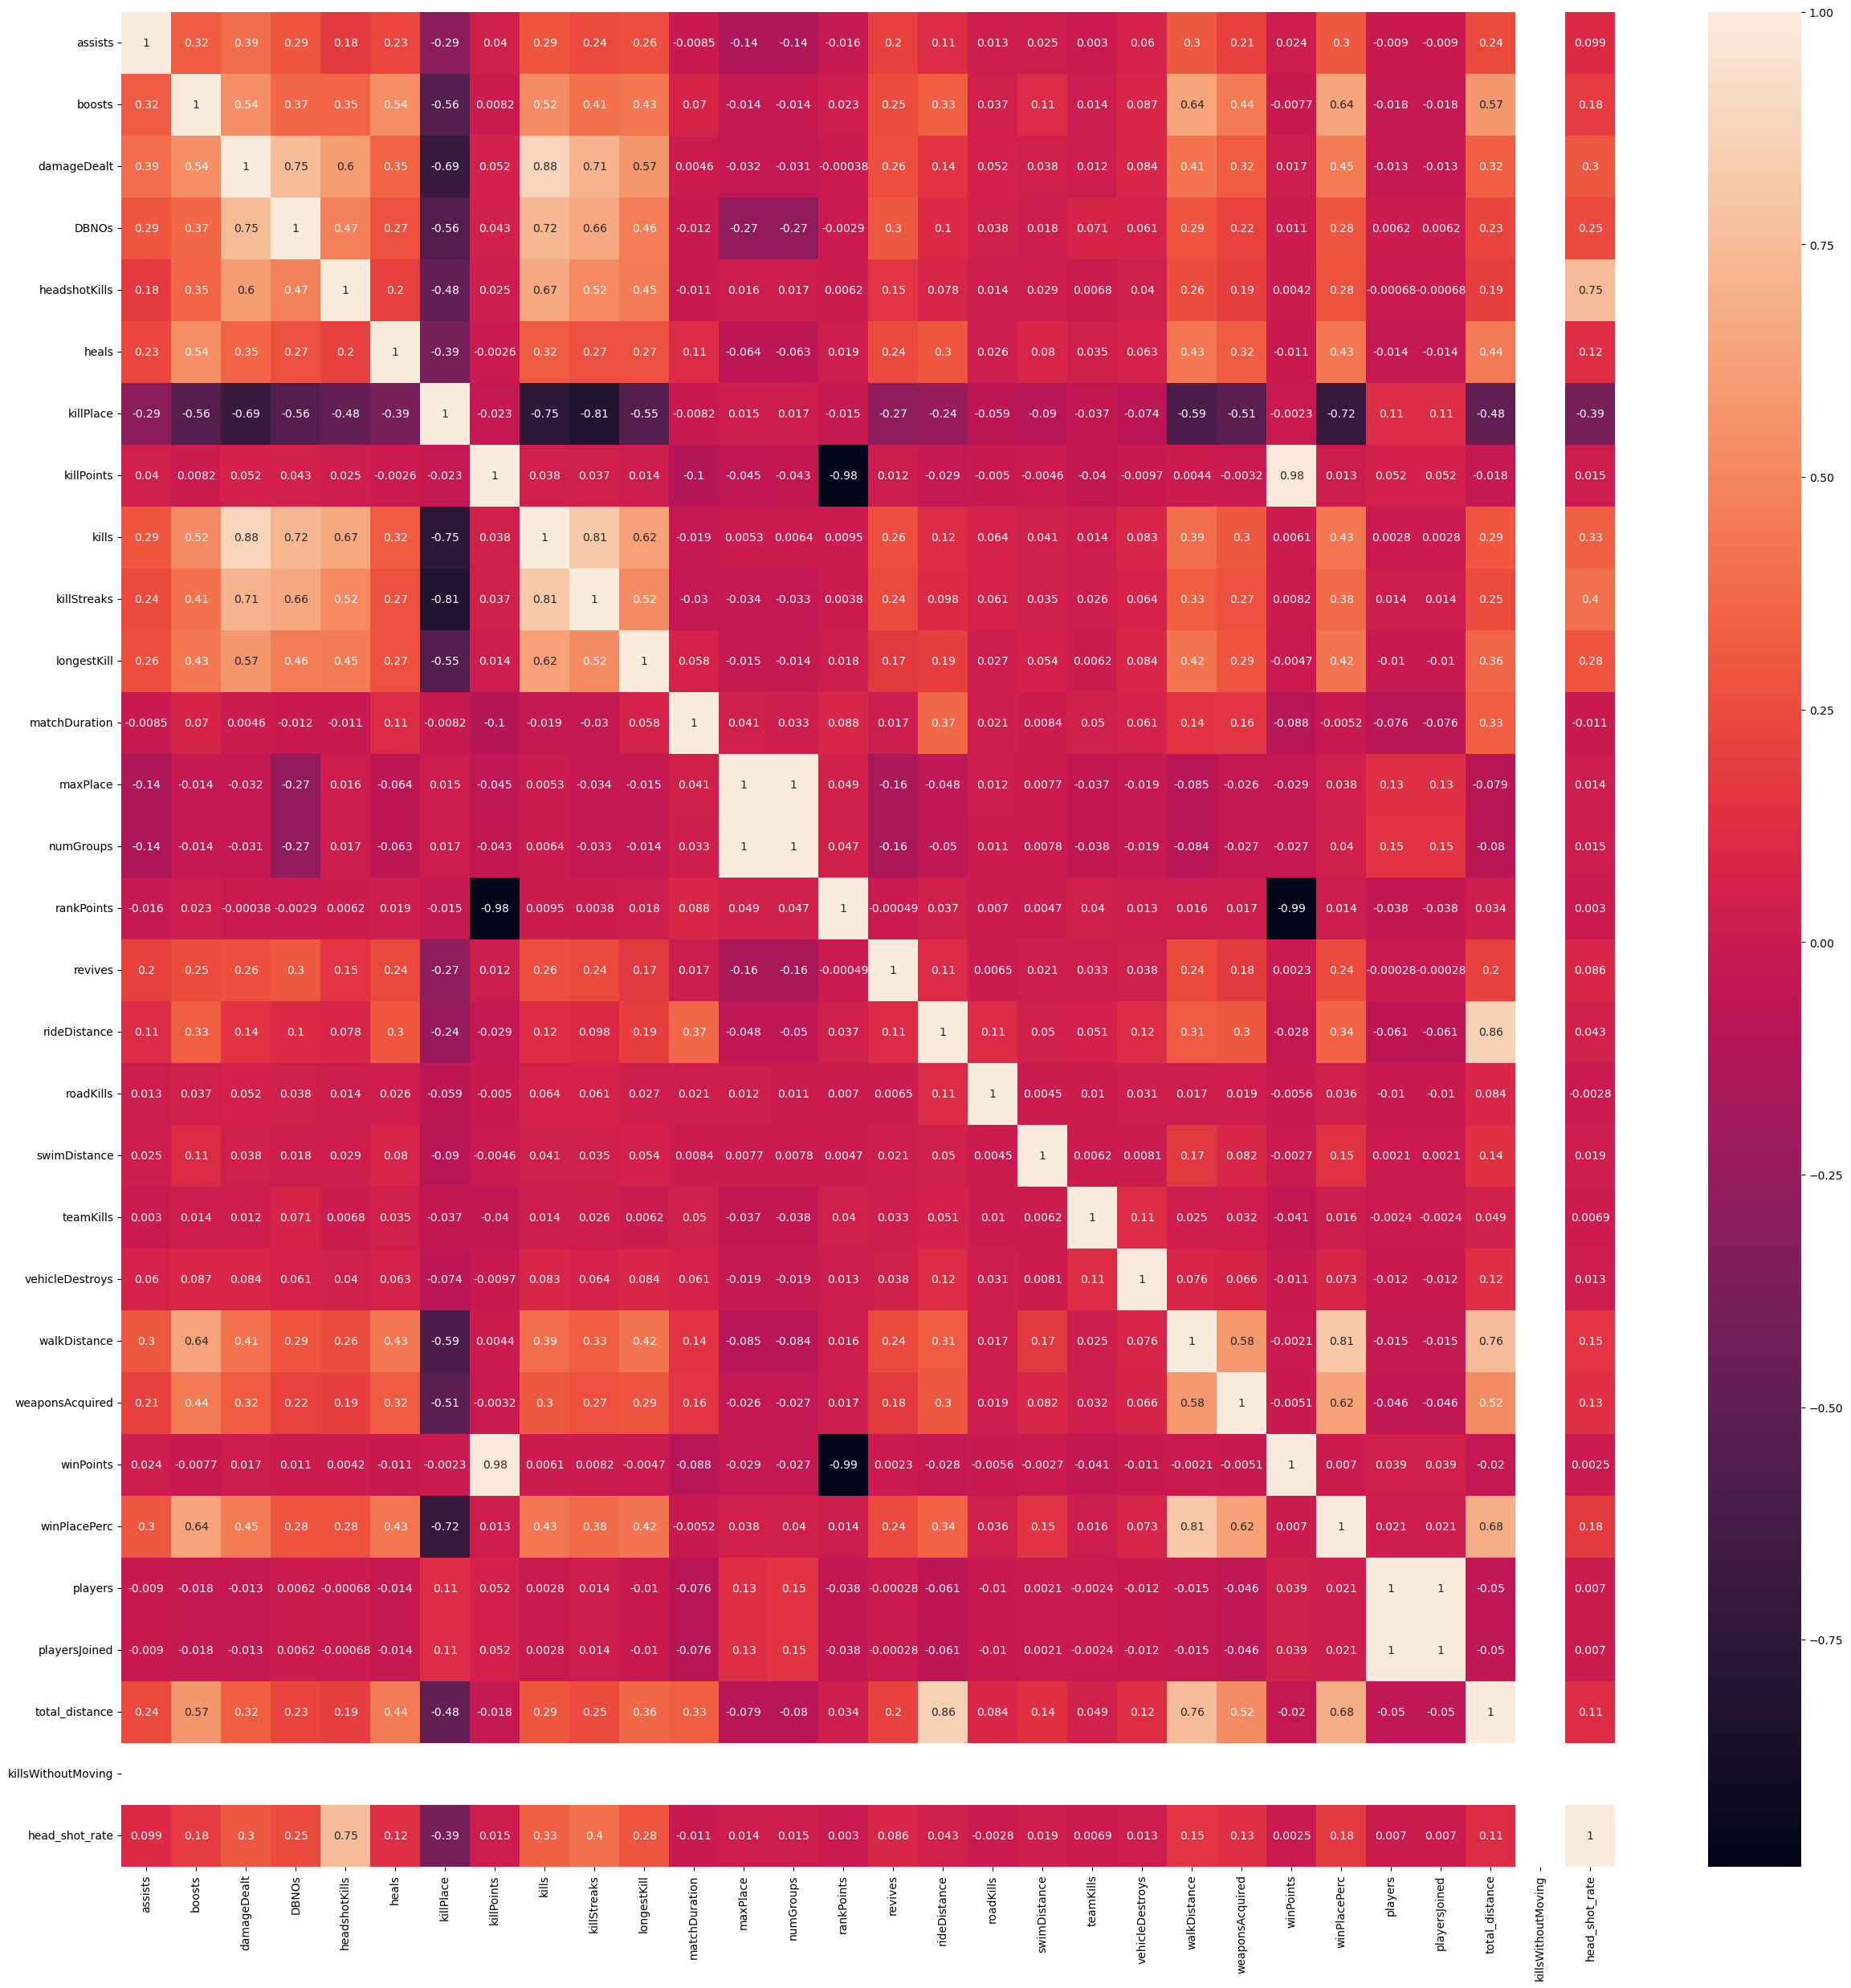

In [69]:
plt.figure(figsize=[30,30])
sns.heatmap(data.corr(),annot=True)
plt.show()

## Feature Engineering

In [72]:
normalising_factor=((100-data['playersJoined'])/100)+1
data['killsNorm']=data['kills']*normalising_factor
data['damageDealtNorm']=data['damageDealt']*normalising_factor
data['maxPlaceNorm']=data['maxPlace']*normalising_factor
data['matchDurationNorm']=data['matchDuration']*normalising_factor
data['traveldistance']=data['walkDistance']+data['swimDistance']+data['rideDistance']
data['healsandBoosts']=data['heals']+data['boosts']
data['assist']=data['assists']+data['revives']

In [73]:
data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'players',
       'playersJoined', 'total_distance', 'killsWithoutMoving',
       'head_shot_rate', 'killsNorm', 'damageDealtNorm', 'maxPlaceNorm',
       'matchDurationNorm', 'traveldistance', 'healsandBoosts', 'assist'],
      dtype='object')

In [75]:
data.drop(['Id','groupId','matchId','assists','boosts','damageDealt','walkDistance','swimDistance','rideDistance','revives','heals','matchDuration','maxPlace','kills'],axis=1,inplace=True)

## ML - Catboost Model

## Handling Categorical Data

In [117]:
x=data.drop(['winPlacePerc'],axis=1)
y=data['winPlacePerc']

In [118]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,total_distance,killsWithoutMoving,head_shot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsandBoosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,29.12,1358.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,99.7023,28.34,1936.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,69.3600,51.00,1344.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,35.8610,33.79,1565.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,1.03,103.0000,99.91,1466.72,49.7500,0,0


In [119]:
x=pd.get_dummies(x,columns=['matchType','killsWithoutMoving'])

In [120]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killsWithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [121]:
features=x.columns

In [122]:
features

Index(['DBNOs', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks',
       'longestKill', 'numGroups', 'rankPoints', 'roadKills', 'teamKills',
       'vehicleDestroys', 'weaponsAcquired', 'winPoints', 'players',
       'playersJoined', 'total_distance', 'head_shot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsandBoosts', 'assist', 'matchType_crashfpp',
       'matchType_crashtpp', 'matchType_duo', 'matchType_duo-fpp',
       'matchType_flarefpp', 'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp', 'killsWithoutMoving_False'],
      dtype='object')

In [123]:
x.shape

(4436196, 41)

In [124]:
features.shape

(41,)

In [125]:
data['matchType'].value_counts()

squad-fpp           1754727
duo-fpp              995997
squad                625291
solo-fpp             536209
duo                  313185
solo                 181452
normal-squad-fpp      13064
crashfpp               6274
normal-duo-fpp         5002
flaretpp               2497
normal-solo-fpp         843
flarefpp                717
crashtpp                367
normal-squad            305
normal-duo              144
normal-solo             122
Name: matchType, dtype: int64

## Scalling the data

In [126]:
sc=StandardScaler()
sc.fit(x)
x=pd.DataFrame(sc.transform(x))

In [127]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-0.583129,-0.384346,0.449314,1.172491,-0.765130,-0.459627,-0.732890,-1.212388,-0.049563,-0.142506,...,-0.033598,-0.005244,-0.013786,-0.008292,-0.054347,-0.206511,-0.370796,-0.405067,1.236180,0.0
1,-0.583129,-0.384346,0.340021,-0.804730,-0.765130,-0.459627,-0.775864,0.803567,-0.049563,-0.142506,...,-0.033598,-0.005244,-0.013786,-0.008292,-0.054347,-0.206511,-0.370796,-0.405067,1.236180,0.0
2,-0.583129,-0.384346,-0.024286,-0.804730,-0.765130,-0.459627,0.169557,0.813070,-0.049563,-0.142506,...,-0.033598,-0.005244,-0.013786,-0.008292,-0.054347,-0.206511,-0.370796,-0.405067,-0.808944,0.0
3,-0.583129,-0.384346,0.995776,-0.804730,-0.765130,-0.459627,-0.560996,0.700393,-0.049563,-0.142506,...,-0.033598,-0.005244,-0.013786,-0.008292,-0.054347,-0.206511,-0.370796,-0.405067,1.236180,0.0
4,-0.583129,-0.384346,-0.097148,-0.804730,0.647793,0.727591,2.232292,0.906740,-0.049563,-0.142506,...,-0.033598,-0.005244,-0.013786,-0.008292,-0.054347,-0.206511,2.696898,-0.405067,-0.808944,0.0


## Splitting the data

In [128]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [129]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3105337, 41) (3105337,)
(1330859, 41) (1330859,)


## CatBoosting Model

In [89]:
import catboost as cb

In [90]:
train_dataset=cb.Pool(x_train,y_train)
test_dataset=cb.Pool(x_test,y_test)

In [92]:
model=cb.CatBoostRegressor(loss_function='RMSE')

## Grid Search

In [93]:
# GRID Search

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482708	test: 0.5481051	best: 0.5481051 (0)	total: 428ms	remaining: 42.4s
1:	learn: 0.5334139	test: 0.5332583	best: 0.5332583 (1)	total: 560ms	remaining: 27.4s
2:	learn: 0.5190531	test: 0.5189101	best: 0.5189101 (2)	total: 698ms	remaining: 22.6s
3:	learn: 0.5051551	test: 0.5050191	best: 0.5050191 (3)	total: 814ms	remaining: 19.5s
4:	learn: 0.4916824	test: 0.4915542	best: 0.4915542 (4)	total: 946ms	remaining: 18s
5:	learn: 0.4786509	test: 0.4785280	best: 0.4785280 (5)	total: 1.06s	remaining: 16.7s
6:	learn: 0.4660716	test: 0.4659550	best: 0.4659550 (6)	total: 1.19s	remaining: 15.8s
7:	learn: 0.4539162	test: 0.4538074	best: 0.4538074 (7)	total: 1.31s	remaining: 15.1s
8:	learn: 0.4420904	test: 0.4419898	best: 0.4419898 (8)	total: 1.47s	remaining: 14.9s
9:	learn: 0.4306644	test: 0.4305713	best: 0.4305713 (9)	total: 1.6s	remaining: 14.4s
10:	learn: 0.4196361	test: 0.4195496	best: 0.4195496 (10)	total: 1.74s	remaining: 14.1s
11:	learn: 0.4089974	test: 0.4089155	best: 0.4089155 (1

94:	learn: 0.1397699	test: 0.1398718	best: 0.1398718 (94)	total: 12.6s	remaining: 661ms
95:	learn: 0.1393855	test: 0.1394859	best: 0.1394859 (95)	total: 12.7s	remaining: 529ms
96:	learn: 0.1390055	test: 0.1391045	best: 0.1391045 (96)	total: 12.8s	remaining: 397ms
97:	learn: 0.1385958	test: 0.1386942	best: 0.1386942 (97)	total: 13s	remaining: 265ms
98:	learn: 0.1382447	test: 0.1383435	best: 0.1383435 (98)	total: 13.1s	remaining: 132ms
99:	learn: 0.1379035	test: 0.1380011	best: 0.1380011 (99)	total: 13.3s	remaining: 0us

bestTest = 0.1380010522
bestIteration = 99

0:	loss: 0.1380011	best: 0.1380011 (0)	total: 15.5s	remaining: 3m 52s
0:	learn: 0.5126363	test: 0.5124855	best: 0.5124855 (0)	total: 158ms	remaining: 15.6s
1:	learn: 0.4671861	test: 0.4670679	best: 0.4670679 (1)	total: 295ms	remaining: 14.4s
2:	learn: 0.4265412	test: 0.4264423	best: 0.4264423 (2)	total: 429ms	remaining: 13.9s
3:	learn: 0.3903174	test: 0.3902451	best: 0.3902451 (3)	total: 558ms	remaining: 13.4s
4:	learn: 0.35815

87:	learn: 0.1172386	test: 0.1173061	best: 0.1173061 (87)	total: 11.6s	remaining: 1.58s
88:	learn: 0.1171306	test: 0.1171963	best: 0.1171963 (88)	total: 11.7s	remaining: 1.45s
89:	learn: 0.1170073	test: 0.1170723	best: 0.1170723 (89)	total: 11.9s	remaining: 1.32s
90:	learn: 0.1166943	test: 0.1167551	best: 0.1167551 (90)	total: 12.1s	remaining: 1.2s
91:	learn: 0.1165320	test: 0.1165951	best: 0.1165951 (91)	total: 12.2s	remaining: 1.06s
92:	learn: 0.1164248	test: 0.1164930	best: 0.1164930 (92)	total: 12.4s	remaining: 931ms
93:	learn: 0.1163269	test: 0.1163989	best: 0.1163989 (93)	total: 12.5s	remaining: 800ms
94:	learn: 0.1162437	test: 0.1163151	best: 0.1163151 (94)	total: 12.7s	remaining: 669ms
95:	learn: 0.1161464	test: 0.1162194	best: 0.1162194 (95)	total: 12.9s	remaining: 539ms
96:	learn: 0.1160580	test: 0.1161294	best: 0.1161294 (96)	total: 13.1s	remaining: 405ms
97:	learn: 0.1156775	test: 0.1157493	best: 0.1157493 (97)	total: 13.3s	remaining: 272ms
98:	learn: 0.1155835	test: 0.1156

81:	learn: 0.1466047	test: 0.1467031	best: 0.1467031 (81)	total: 13.8s	remaining: 11.4s
82:	learn: 0.1459823	test: 0.1460838	best: 0.1460838 (82)	total: 14s	remaining: 11.3s
83:	learn: 0.1453694	test: 0.1454714	best: 0.1454714 (83)	total: 14.1s	remaining: 11.1s
84:	learn: 0.1447341	test: 0.1448339	best: 0.1448339 (84)	total: 14.2s	remaining: 10.9s
85:	learn: 0.1441779	test: 0.1442766	best: 0.1442766 (85)	total: 14.4s	remaining: 10.7s
86:	learn: 0.1436456	test: 0.1437451	best: 0.1437451 (86)	total: 14.5s	remaining: 10.5s
87:	learn: 0.1430445	test: 0.1431438	best: 0.1431438 (87)	total: 14.7s	remaining: 10.4s
88:	learn: 0.1425334	test: 0.1426327	best: 0.1426327 (88)	total: 14.8s	remaining: 10.2s
89:	learn: 0.1420605	test: 0.1421621	best: 0.1421621 (89)	total: 15s	remaining: 9.98s
90:	learn: 0.1415917	test: 0.1416951	best: 0.1416951 (90)	total: 15.1s	remaining: 9.79s
91:	learn: 0.1411457	test: 0.1412471	best: 0.1412471 (91)	total: 15.2s	remaining: 9.61s
92:	learn: 0.1406436	test: 0.1407441

24:	learn: 0.1440475	test: 0.1441649	best: 0.1441649 (24)	total: 3.71s	remaining: 18.5s
25:	learn: 0.1422609	test: 0.1423796	best: 0.1423796 (25)	total: 3.84s	remaining: 18.3s
26:	learn: 0.1405170	test: 0.1406283	best: 0.1406283 (26)	total: 3.99s	remaining: 18.2s
27:	learn: 0.1391947	test: 0.1393019	best: 0.1393019 (27)	total: 4.12s	remaining: 18s
28:	learn: 0.1378288	test: 0.1379332	best: 0.1379332 (28)	total: 4.25s	remaining: 17.7s
29:	learn: 0.1367219	test: 0.1368247	best: 0.1368247 (29)	total: 4.37s	remaining: 17.5s
30:	learn: 0.1357339	test: 0.1358433	best: 0.1358433 (30)	total: 4.5s	remaining: 17.3s
31:	learn: 0.1347723	test: 0.1348749	best: 0.1348749 (31)	total: 4.63s	remaining: 17.1s
32:	learn: 0.1340178	test: 0.1341202	best: 0.1341202 (32)	total: 4.77s	remaining: 16.9s
33:	learn: 0.1333277	test: 0.1334360	best: 0.1334360 (33)	total: 4.89s	remaining: 16.7s
34:	learn: 0.1326337	test: 0.1327334	best: 0.1327334 (34)	total: 5.03s	remaining: 16.5s
35:	learn: 0.1315907	test: 0.131686

119:	learn: 0.1126671	test: 0.1127455	best: 0.1127455 (119)	total: 16.6s	remaining: 4.15s
120:	learn: 0.1125929	test: 0.1126719	best: 0.1126719 (120)	total: 16.7s	remaining: 4.01s
121:	learn: 0.1124361	test: 0.1125167	best: 0.1125167 (121)	total: 16.9s	remaining: 3.87s
122:	learn: 0.1123429	test: 0.1124234	best: 0.1124234 (122)	total: 17s	remaining: 3.73s
123:	learn: 0.1122259	test: 0.1123025	best: 0.1123025 (123)	total: 17.2s	remaining: 3.6s
124:	learn: 0.1121053	test: 0.1121785	best: 0.1121785 (124)	total: 17.3s	remaining: 3.46s
125:	learn: 0.1120478	test: 0.1121192	best: 0.1121192 (125)	total: 17.4s	remaining: 3.32s
126:	learn: 0.1119460	test: 0.1120163	best: 0.1120163 (126)	total: 17.6s	remaining: 3.19s
127:	learn: 0.1118744	test: 0.1119442	best: 0.1119442 (127)	total: 17.8s	remaining: 3.05s
128:	learn: 0.1118215	test: 0.1118935	best: 0.1118935 (128)	total: 17.9s	remaining: 2.91s
129:	learn: 0.1117623	test: 0.1118370	best: 0.1118370 (129)	total: 18s	remaining: 2.77s
130:	learn: 0.1

61:	learn: 0.1520273	test: 0.1520578	best: 0.1520578 (61)	total: 11.1s	remaining: 6.82s
62:	learn: 0.1502337	test: 0.1502660	best: 0.1502660 (62)	total: 11.3s	remaining: 6.65s
63:	learn: 0.1487115	test: 0.1487476	best: 0.1487476 (63)	total: 11.5s	remaining: 6.47s
64:	learn: 0.1470676	test: 0.1471054	best: 0.1471054 (64)	total: 11.7s	remaining: 6.3s
65:	learn: 0.1456502	test: 0.1456887	best: 0.1456887 (65)	total: 11.9s	remaining: 6.12s
66:	learn: 0.1442359	test: 0.1442749	best: 0.1442749 (66)	total: 12s	remaining: 5.93s
67:	learn: 0.1429431	test: 0.1429801	best: 0.1429801 (67)	total: 12.2s	remaining: 5.75s
68:	learn: 0.1417363	test: 0.1417731	best: 0.1417731 (68)	total: 12.4s	remaining: 5.57s
69:	learn: 0.1405599	test: 0.1405963	best: 0.1405963 (69)	total: 12.6s	remaining: 5.39s
70:	learn: 0.1392916	test: 0.1393279	best: 0.1393279 (70)	total: 12.8s	remaining: 5.22s
71:	learn: 0.1381722	test: 0.1382111	best: 0.1382111 (71)	total: 13s	remaining: 5.05s
72:	learn: 0.1371463	test: 0.1371849	

54:	learn: 0.1052169	test: 0.1053349	best: 0.1053349 (54)	total: 9.36s	remaining: 7.66s
55:	learn: 0.1049053	test: 0.1050194	best: 0.1050194 (55)	total: 9.54s	remaining: 7.49s
56:	learn: 0.1047054	test: 0.1048200	best: 0.1048200 (56)	total: 9.71s	remaining: 7.32s
57:	learn: 0.1042777	test: 0.1043922	best: 0.1043922 (57)	total: 9.89s	remaining: 7.16s
58:	learn: 0.1038858	test: 0.1040037	best: 0.1040037 (58)	total: 10.1s	remaining: 6.99s
59:	learn: 0.1037244	test: 0.1038403	best: 0.1038403 (59)	total: 10.2s	remaining: 6.82s
60:	learn: 0.1035426	test: 0.1036601	best: 0.1036601 (60)	total: 10.4s	remaining: 6.63s
61:	learn: 0.1033088	test: 0.1034249	best: 0.1034249 (61)	total: 10.5s	remaining: 6.46s
62:	learn: 0.1031142	test: 0.1032320	best: 0.1032320 (62)	total: 10.7s	remaining: 6.27s
63:	learn: 0.1028134	test: 0.1029307	best: 0.1029307 (63)	total: 10.8s	remaining: 6.09s
64:	learn: 0.1026503	test: 0.1027649	best: 0.1027649 (64)	total: 11s	remaining: 5.91s
65:	learn: 0.1025300	test: 0.10264

48:	learn: 0.1803987	test: 0.1804187	best: 0.1804187 (48)	total: 9.58s	remaining: 19.8s
49:	learn: 0.1776215	test: 0.1776432	best: 0.1776432 (49)	total: 9.77s	remaining: 19.5s
50:	learn: 0.1749590	test: 0.1749793	best: 0.1749793 (50)	total: 9.96s	remaining: 19.3s
51:	learn: 0.1723936	test: 0.1724122	best: 0.1724122 (51)	total: 10.1s	remaining: 19.1s
52:	learn: 0.1699337	test: 0.1699552	best: 0.1699552 (52)	total: 10.4s	remaining: 19s
53:	learn: 0.1675900	test: 0.1676099	best: 0.1676099 (53)	total: 10.7s	remaining: 19s
54:	learn: 0.1653588	test: 0.1653798	best: 0.1653798 (54)	total: 10.9s	remaining: 18.9s
55:	learn: 0.1631773	test: 0.1632014	best: 0.1632014 (55)	total: 11.1s	remaining: 18.7s
56:	learn: 0.1611354	test: 0.1611612	best: 0.1611612 (56)	total: 11.3s	remaining: 18.4s
57:	learn: 0.1591163	test: 0.1591424	best: 0.1591424 (57)	total: 11.5s	remaining: 18.2s
58:	learn: 0.1572148	test: 0.1572432	best: 0.1572432 (58)	total: 11.7s	remaining: 18s
59:	learn: 0.1553965	test: 0.1554266	b

142:	learn: 0.1105484	test: 0.1106244	best: 0.1106244 (142)	total: 27.1s	remaining: 1.33s
143:	learn: 0.1104216	test: 0.1104982	best: 0.1104982 (143)	total: 27.3s	remaining: 1.14s
144:	learn: 0.1101378	test: 0.1102159	best: 0.1102159 (144)	total: 27.5s	remaining: 948ms
145:	learn: 0.1100467	test: 0.1101250	best: 0.1101250 (145)	total: 27.7s	remaining: 758ms
146:	learn: 0.1099488	test: 0.1100263	best: 0.1100263 (146)	total: 27.9s	remaining: 568ms
147:	learn: 0.1098530	test: 0.1099312	best: 0.1099312 (147)	total: 28s	remaining: 379ms
148:	learn: 0.1096211	test: 0.1097005	best: 0.1097005 (148)	total: 28.2s	remaining: 189ms
149:	learn: 0.1095354	test: 0.1096148	best: 0.1096148 (149)	total: 28.4s	remaining: 0us

bestTest = 0.1096148007
bestIteration = 149

6:	loss: 0.1096148	best: 0.0956493 (5)	total: 2m 18s	remaining: 2m 57s
0:	learn: 0.5114497	test: 0.5112957	best: 0.5112957 (0)	total: 210ms	remaining: 31.3s
1:	learn: 0.4647585	test: 0.4646432	best: 0.4646432 (1)	total: 390ms	remaining: 2

86:	learn: 0.0976644	test: 0.0977975	best: 0.0977975 (86)	total: 16.2s	remaining: 11.7s
87:	learn: 0.0973935	test: 0.0975278	best: 0.0975278 (87)	total: 16.4s	remaining: 11.5s
88:	learn: 0.0972390	test: 0.0973723	best: 0.0973723 (88)	total: 16.6s	remaining: 11.4s
89:	learn: 0.0971753	test: 0.0973075	best: 0.0973075 (89)	total: 16.7s	remaining: 11.2s
90:	learn: 0.0970226	test: 0.0971533	best: 0.0971533 (90)	total: 16.9s	remaining: 11s
91:	learn: 0.0968845	test: 0.0970157	best: 0.0970157 (91)	total: 17.1s	remaining: 10.8s
92:	learn: 0.0966776	test: 0.0968102	best: 0.0968102 (92)	total: 17.3s	remaining: 10.6s
93:	learn: 0.0965855	test: 0.0967163	best: 0.0967163 (93)	total: 17.4s	remaining: 10.4s
94:	learn: 0.0964040	test: 0.0965353	best: 0.0965353 (94)	total: 17.6s	remaining: 10.2s
95:	learn: 0.0962849	test: 0.0964166	best: 0.0964166 (95)	total: 17.8s	remaining: 10s
96:	learn: 0.0961025	test: 0.0962327	best: 0.0962327 (96)	total: 18s	remaining: 9.83s
97:	learn: 0.0958974	test: 0.0960281	b

28:	learn: 0.2601180	test: 0.2600799	best: 0.2600799 (28)	total: 7.78s	remaining: 19.1s
29:	learn: 0.2540040	test: 0.2539699	best: 0.2539699 (29)	total: 8.11s	remaining: 18.9s
30:	learn: 0.2481166	test: 0.2480842	best: 0.2480842 (30)	total: 8.46s	remaining: 18.8s
31:	learn: 0.2424501	test: 0.2424185	best: 0.2424185 (31)	total: 8.75s	remaining: 18.6s
32:	learn: 0.2369848	test: 0.2369566	best: 0.2369566 (32)	total: 9.05s	remaining: 18.4s
33:	learn: 0.2316913	test: 0.2316669	best: 0.2316669 (33)	total: 9.35s	remaining: 18.2s
34:	learn: 0.2266162	test: 0.2265938	best: 0.2265938 (34)	total: 9.64s	remaining: 17.9s
35:	learn: 0.2216784	test: 0.2216595	best: 0.2216595 (35)	total: 9.94s	remaining: 17.7s
36:	learn: 0.2169566	test: 0.2169404	best: 0.2169404 (36)	total: 10.2s	remaining: 17.4s
37:	learn: 0.2123829	test: 0.2123694	best: 0.2123694 (37)	total: 10.5s	remaining: 17.2s
38:	learn: 0.2079550	test: 0.2079423	best: 0.2079423 (38)	total: 10.8s	remaining: 16.9s
39:	learn: 0.2037098	test: 0.203

21:	learn: 0.1239513	test: 0.1240225	best: 0.1240225 (21)	total: 6.03s	remaining: 21.4s
22:	learn: 0.1209588	test: 0.1210290	best: 0.1210290 (22)	total: 6.29s	remaining: 21.1s
23:	learn: 0.1181808	test: 0.1182719	best: 0.1182719 (23)	total: 6.54s	remaining: 20.7s
24:	learn: 0.1159637	test: 0.1160551	best: 0.1160551 (24)	total: 6.82s	remaining: 20.4s
25:	learn: 0.1137640	test: 0.1138592	best: 0.1138592 (25)	total: 7.1s	remaining: 20.2s
26:	learn: 0.1120493	test: 0.1121532	best: 0.1121532 (26)	total: 7.35s	remaining: 19.9s
27:	learn: 0.1104052	test: 0.1105098	best: 0.1105098 (27)	total: 7.61s	remaining: 19.6s
28:	learn: 0.1089251	test: 0.1090432	best: 0.1090432 (28)	total: 7.93s	remaining: 19.4s
29:	learn: 0.1077455	test: 0.1078678	best: 0.1078678 (29)	total: 8.17s	remaining: 19.1s
30:	learn: 0.1067578	test: 0.1068842	best: 0.1068842 (30)	total: 8.41s	remaining: 18.7s
31:	learn: 0.1056963	test: 0.1058292	best: 0.1058292 (31)	total: 8.68s	remaining: 18.4s
32:	learn: 0.1048804	test: 0.1050

14:	learn: 0.3714791	test: 0.3713921	best: 0.3713921 (14)	total: 4.26s	remaining: 38.3s
15:	learn: 0.3617374	test: 0.3616556	best: 0.3616556 (15)	total: 4.62s	remaining: 38.7s
16:	learn: 0.3522715	test: 0.3521918	best: 0.3521918 (16)	total: 4.9s	remaining: 38.3s
17:	learn: 0.3430895	test: 0.3430135	best: 0.3430135 (17)	total: 5.14s	remaining: 37.7s
18:	learn: 0.3342103	test: 0.3341367	best: 0.3341367 (18)	total: 5.39s	remaining: 37.1s
19:	learn: 0.3255890	test: 0.3255214	best: 0.3255214 (19)	total: 5.72s	remaining: 37.2s
20:	learn: 0.3173227	test: 0.3172590	best: 0.3172590 (20)	total: 6.05s	remaining: 37.2s
21:	learn: 0.3093175	test: 0.3092556	best: 0.3092556 (21)	total: 6.41s	remaining: 37.3s
22:	learn: 0.3015463	test: 0.3014857	best: 0.3014857 (22)	total: 6.74s	remaining: 37.2s
23:	learn: 0.2940770	test: 0.2940230	best: 0.2940230 (23)	total: 7.05s	remaining: 37s
24:	learn: 0.2868030	test: 0.2867533	best: 0.2867533 (24)	total: 7.37s	remaining: 36.8s
25:	learn: 0.2797864	test: 0.279742

108:	learn: 0.1062030	test: 0.1063026	best: 0.1063026 (108)	total: 30s	remaining: 11.3s
109:	learn: 0.1059032	test: 0.1060039	best: 0.1060039 (109)	total: 30.4s	remaining: 11.1s
110:	learn: 0.1056650	test: 0.1057672	best: 0.1057672 (110)	total: 30.7s	remaining: 10.8s
111:	learn: 0.1052864	test: 0.1053909	best: 0.1053909 (111)	total: 30.9s	remaining: 10.5s
112:	learn: 0.1050180	test: 0.1051255	best: 0.1051255 (112)	total: 31.3s	remaining: 10.3s
113:	learn: 0.1047498	test: 0.1048590	best: 0.1048590 (113)	total: 31.6s	remaining: 9.99s
114:	learn: 0.1044009	test: 0.1045127	best: 0.1045127 (114)	total: 31.9s	remaining: 9.71s
115:	learn: 0.1041728	test: 0.1042866	best: 0.1042866 (115)	total: 32.2s	remaining: 9.45s
116:	learn: 0.1038333	test: 0.1039463	best: 0.1039463 (116)	total: 32.5s	remaining: 9.17s
117:	learn: 0.1036090	test: 0.1037247	best: 0.1037247 (117)	total: 32.9s	remaining: 8.91s
118:	learn: 0.1033596	test: 0.1034761	best: 0.1034761 (118)	total: 33.1s	remaining: 8.63s
119:	learn: 

50:	learn: 0.0963944	test: 0.0965533	best: 0.0965533 (50)	total: 13.5s	remaining: 26.2s
51:	learn: 0.0960241	test: 0.0961848	best: 0.0961848 (51)	total: 13.8s	remaining: 25.9s
52:	learn: 0.0957516	test: 0.0959145	best: 0.0959145 (52)	total: 14s	remaining: 25.5s
53:	learn: 0.0954196	test: 0.0955834	best: 0.0955834 (53)	total: 14.2s	remaining: 25.3s
54:	learn: 0.0950813	test: 0.0952488	best: 0.0952488 (54)	total: 14.5s	remaining: 25s
55:	learn: 0.0948616	test: 0.0950334	best: 0.0950334 (55)	total: 14.7s	remaining: 24.7s
56:	learn: 0.0945549	test: 0.0947275	best: 0.0947275 (56)	total: 15s	remaining: 24.4s
57:	learn: 0.0942357	test: 0.0944114	best: 0.0944114 (57)	total: 15.2s	remaining: 24.1s
58:	learn: 0.0938281	test: 0.0940031	best: 0.0940031 (58)	total: 15.4s	remaining: 23.8s
59:	learn: 0.0936301	test: 0.0938070	best: 0.0938070 (59)	total: 15.7s	remaining: 23.5s
60:	learn: 0.0933307	test: 0.0935059	best: 0.0935059 (60)	total: 15.9s	remaining: 23.1s
61:	learn: 0.0931794	test: 0.0933529	b

143:	learn: 0.0849795	test: 0.0851516	best: 0.0851516 (143)	total: 34.8s	remaining: 1.45s
144:	learn: 0.0849475	test: 0.0851196	best: 0.0851196 (144)	total: 34.9s	remaining: 1.2s
145:	learn: 0.0848823	test: 0.0850558	best: 0.0850558 (145)	total: 35.3s	remaining: 966ms
146:	learn: 0.0847955	test: 0.0849677	best: 0.0849677 (146)	total: 35.5s	remaining: 724ms
147:	learn: 0.0847343	test: 0.0849052	best: 0.0849052 (147)	total: 35.7s	remaining: 483ms
148:	learn: 0.0846532	test: 0.0848222	best: 0.0848222 (148)	total: 36s	remaining: 242ms
149:	learn: 0.0845977	test: 0.0847682	best: 0.0847682 (149)	total: 36.2s	remaining: 0us

bestTest = 0.08476816387
bestIteration = 149

11:	loss: 0.0847682	best: 0.0847682 (11)	total: 4m 58s	remaining: 1m 39s
0:	learn: 0.5476133	test: 0.5474492	best: 0.5474492 (0)	total: 312ms	remaining: 30.8s
1:	learn: 0.5321254	test: 0.5319648	best: 0.5319648 (1)	total: 747ms	remaining: 36.6s
2:	learn: 0.5170735	test: 0.5169224	best: 0.5169224 (2)	total: 1.07s	remaining: 34.

86:	learn: 0.1082696	test: 0.1083632	best: 0.1083632 (86)	total: 27.5s	remaining: 4.11s
87:	learn: 0.1076737	test: 0.1077682	best: 0.1077682 (87)	total: 27.8s	remaining: 3.79s
88:	learn: 0.1070937	test: 0.1071907	best: 0.1071907 (88)	total: 28.1s	remaining: 3.47s
89:	learn: 0.1065533	test: 0.1066520	best: 0.1066520 (89)	total: 28.4s	remaining: 3.15s
90:	learn: 0.1060543	test: 0.1061540	best: 0.1061540 (90)	total: 28.6s	remaining: 2.83s
91:	learn: 0.1055739	test: 0.1056754	best: 0.1056754 (91)	total: 28.9s	remaining: 2.52s
92:	learn: 0.1051205	test: 0.1052251	best: 0.1052251 (92)	total: 29.2s	remaining: 2.2s
93:	learn: 0.1045438	test: 0.1046493	best: 0.1046493 (93)	total: 29.5s	remaining: 1.88s
94:	learn: 0.1040439	test: 0.1041501	best: 0.1041501 (94)	total: 29.7s	remaining: 1.56s
95:	learn: 0.1036382	test: 0.1037445	best: 0.1037445 (95)	total: 30s	remaining: 1.25s
96:	learn: 0.1032183	test: 0.1033272	best: 0.1033272 (96)	total: 30.3s	remaining: 938ms
97:	learn: 0.1027974	test: 0.102907

79:	learn: 0.0857463	test: 0.0859363	best: 0.0859363 (79)	total: 23.3s	remaining: 5.83s
80:	learn: 0.0856649	test: 0.0858583	best: 0.0858583 (80)	total: 23.5s	remaining: 5.52s
81:	learn: 0.0855830	test: 0.0857784	best: 0.0857784 (81)	total: 23.9s	remaining: 5.24s
82:	learn: 0.0854970	test: 0.0856912	best: 0.0856912 (82)	total: 24.1s	remaining: 4.93s
83:	learn: 0.0853922	test: 0.0855834	best: 0.0855834 (83)	total: 24.4s	remaining: 4.64s
84:	learn: 0.0853424	test: 0.0855331	best: 0.0855331 (84)	total: 24.6s	remaining: 4.34s
85:	learn: 0.0852685	test: 0.0854603	best: 0.0854603 (85)	total: 24.8s	remaining: 4.04s
86:	learn: 0.0852319	test: 0.0854240	best: 0.0854240 (86)	total: 25s	remaining: 3.73s
87:	learn: 0.0851706	test: 0.0853663	best: 0.0853663 (87)	total: 25.2s	remaining: 3.43s
88:	learn: 0.0850829	test: 0.0852787	best: 0.0852787 (88)	total: 25.5s	remaining: 3.15s
89:	learn: 0.0849777	test: 0.0851701	best: 0.0851701 (89)	total: 25.7s	remaining: 2.86s
90:	learn: 0.0848705	test: 0.08506

72:	learn: 0.1199591	test: 0.1200255	best: 0.1200255 (72)	total: 21.5s	remaining: 22.7s
73:	learn: 0.1188830	test: 0.1189508	best: 0.1189508 (73)	total: 21.7s	remaining: 22.3s
74:	learn: 0.1178289	test: 0.1178994	best: 0.1178994 (74)	total: 22s	remaining: 22s
75:	learn: 0.1168271	test: 0.1169001	best: 0.1169001 (75)	total: 22.2s	remaining: 21.7s
76:	learn: 0.1158774	test: 0.1159525	best: 0.1159525 (76)	total: 22.5s	remaining: 21.3s
77:	learn: 0.1149389	test: 0.1150177	best: 0.1150177 (77)	total: 22.8s	remaining: 21s
78:	learn: 0.1140862	test: 0.1141681	best: 0.1141681 (78)	total: 23s	remaining: 20.7s
79:	learn: 0.1132377	test: 0.1133205	best: 0.1133205 (79)	total: 23.3s	remaining: 20.3s
80:	learn: 0.1124578	test: 0.1125402	best: 0.1125402 (80)	total: 23.5s	remaining: 20s
81:	learn: 0.1116853	test: 0.1117681	best: 0.1117681 (81)	total: 23.8s	remaining: 19.7s
82:	learn: 0.1109321	test: 0.1110190	best: 0.1110190 (82)	total: 24s	remaining: 19.4s
83:	learn: 0.1102350	test: 0.1103230	best: 0

14:	learn: 0.1587881	test: 0.1588235	best: 0.1588235 (14)	total: 4.23s	remaining: 38.1s
15:	learn: 0.1501478	test: 0.1501874	best: 0.1501874 (15)	total: 4.46s	remaining: 37.4s
16:	learn: 0.1425160	test: 0.1425613	best: 0.1425613 (16)	total: 4.77s	remaining: 37.4s
17:	learn: 0.1359416	test: 0.1359904	best: 0.1359904 (17)	total: 5.04s	remaining: 37s
18:	learn: 0.1300455	test: 0.1301089	best: 0.1301089 (18)	total: 5.34s	remaining: 36.8s
19:	learn: 0.1251128	test: 0.1251862	best: 0.1251862 (19)	total: 5.61s	remaining: 36.5s
20:	learn: 0.1209622	test: 0.1210427	best: 0.1210427 (20)	total: 5.87s	remaining: 36s
21:	learn: 0.1172319	test: 0.1173175	best: 0.1173175 (21)	total: 6.15s	remaining: 35.8s
22:	learn: 0.1139753	test: 0.1140660	best: 0.1140660 (22)	total: 6.43s	remaining: 35.5s
23:	learn: 0.1113094	test: 0.1114032	best: 0.1114032 (23)	total: 6.69s	remaining: 35.1s
24:	learn: 0.1090684	test: 0.1091592	best: 0.1091592 (24)	total: 6.92s	remaining: 34.6s
25:	learn: 0.1071755	test: 0.1072739

109:	learn: 0.0837097	test: 0.0839166	best: 0.0839166 (109)	total: 27.3s	remaining: 9.93s
110:	learn: 0.0836390	test: 0.0838475	best: 0.0838475 (110)	total: 27.6s	remaining: 9.71s
111:	learn: 0.0836027	test: 0.0838131	best: 0.0838131 (111)	total: 27.9s	remaining: 9.47s
112:	learn: 0.0835643	test: 0.0837732	best: 0.0837732 (112)	total: 28.1s	remaining: 9.22s
113:	learn: 0.0834943	test: 0.0837057	best: 0.0837057 (113)	total: 28.4s	remaining: 8.97s
114:	learn: 0.0834397	test: 0.0836531	best: 0.0836531 (114)	total: 28.7s	remaining: 8.74s
115:	learn: 0.0834007	test: 0.0836148	best: 0.0836148 (115)	total: 29s	remaining: 8.49s
116:	learn: 0.0833551	test: 0.0835739	best: 0.0835739 (116)	total: 29.2s	remaining: 8.24s
117:	learn: 0.0833227	test: 0.0835428	best: 0.0835428 (117)	total: 29.5s	remaining: 8.01s
118:	learn: 0.0832985	test: 0.0835186	best: 0.0835186 (118)	total: 29.8s	remaining: 7.75s
119:	learn: 0.0832645	test: 0.0834857	best: 0.0834857 (119)	total: 30s	remaining: 7.51s
120:	learn: 0.

50:	learn: 0.0901369	test: 0.0903343	best: 0.0903343 (50)	total: 12.6s	remaining: 24.6s
51:	learn: 0.0898193	test: 0.0900208	best: 0.0900208 (51)	total: 12.9s	remaining: 24.3s
52:	learn: 0.0894445	test: 0.0896416	best: 0.0896416 (52)	total: 13.1s	remaining: 24s
53:	learn: 0.0893085	test: 0.0895061	best: 0.0895061 (53)	total: 13.3s	remaining: 23.6s
54:	learn: 0.0891137	test: 0.0893072	best: 0.0893072 (54)	total: 13.5s	remaining: 23.3s
55:	learn: 0.0890089	test: 0.0891998	best: 0.0891998 (55)	total: 13.7s	remaining: 22.9s
56:	learn: 0.0888684	test: 0.0890605	best: 0.0890605 (56)	total: 13.9s	remaining: 22.6s
57:	learn: 0.0886634	test: 0.0888525	best: 0.0888525 (57)	total: 14.1s	remaining: 22.3s
58:	learn: 0.0884642	test: 0.0886530	best: 0.0886530 (58)	total: 14.3s	remaining: 22s
59:	learn: 0.0883250	test: 0.0885135	best: 0.0885135 (59)	total: 14.5s	remaining: 21.8s
60:	learn: 0.0881637	test: 0.0883477	best: 0.0883477 (60)	total: 14.7s	remaining: 21.5s
61:	learn: 0.0880326	test: 0.0882180

143:	learn: 0.0822275	test: 0.0824715	best: 0.0824715 (143)	total: 32.1s	remaining: 1.34s
144:	learn: 0.0822036	test: 0.0824490	best: 0.0824490 (144)	total: 32.4s	remaining: 1.11s
145:	learn: 0.0821742	test: 0.0824199	best: 0.0824199 (145)	total: 32.6s	remaining: 894ms
146:	learn: 0.0821528	test: 0.0823992	best: 0.0823992 (146)	total: 32.8s	remaining: 670ms
147:	learn: 0.0821228	test: 0.0823704	best: 0.0823704 (147)	total: 33s	remaining: 446ms
148:	learn: 0.0820931	test: 0.0823439	best: 0.0823439 (148)	total: 33.2s	remaining: 223ms
149:	learn: 0.0820623	test: 0.0823126	best: 0.0823126 (149)	total: 33.4s	remaining: 0us

bestTest = 0.08231260088
bestIteration = 149

Training on fold [1/3]
0:	learn: 0.5106057	test: 0.5101965	best: 0.5101965 (0)	total: 211ms	remaining: 31.4s
1:	learn: 0.4630351	test: 0.4626513	best: 0.4626513 (1)	total: 440ms	remaining: 32.6s
2:	learn: 0.4202578	test: 0.4198913	best: 0.4198913 (2)	total: 683ms	remaining: 33.5s
3:	learn: 0.3819908	test: 0.3816449	best: 0.38

86:	learn: 0.0853527	test: 0.0852263	best: 0.0852263 (86)	total: 21.1s	remaining: 15.3s
87:	learn: 0.0852716	test: 0.0851485	best: 0.0851485 (87)	total: 21.3s	remaining: 15s
88:	learn: 0.0851924	test: 0.0850751	best: 0.0850751 (88)	total: 21.6s	remaining: 14.8s
89:	learn: 0.0851098	test: 0.0849929	best: 0.0849929 (89)	total: 21.8s	remaining: 14.5s
90:	learn: 0.0850204	test: 0.0849074	best: 0.0849074 (90)	total: 22.1s	remaining: 14.3s
91:	learn: 0.0849736	test: 0.0848625	best: 0.0848625 (91)	total: 22.3s	remaining: 14.1s
92:	learn: 0.0848916	test: 0.0847842	best: 0.0847842 (92)	total: 22.5s	remaining: 13.8s
93:	learn: 0.0848320	test: 0.0847242	best: 0.0847242 (93)	total: 22.8s	remaining: 13.6s
94:	learn: 0.0847678	test: 0.0846597	best: 0.0846597 (94)	total: 23s	remaining: 13.3s
95:	learn: 0.0847007	test: 0.0845929	best: 0.0845929 (95)	total: 23.3s	remaining: 13.1s
96:	learn: 0.0846081	test: 0.0845036	best: 0.0845036 (96)	total: 23.5s	remaining: 12.9s
97:	learn: 0.0845561	test: 0.0844527

28:	learn: 0.1021721	test: 0.1022657	best: 0.1022657 (28)	total: 7.14s	remaining: 29.8s
29:	learn: 0.1007991	test: 0.1008965	best: 0.1008965 (29)	total: 7.38s	remaining: 29.5s
30:	learn: 0.0997925	test: 0.0998940	best: 0.0998940 (30)	total: 7.61s	remaining: 29.2s
31:	learn: 0.0988949	test: 0.0989992	best: 0.0989992 (31)	total: 7.84s	remaining: 28.9s
32:	learn: 0.0980894	test: 0.0981944	best: 0.0981944 (32)	total: 8.1s	remaining: 28.7s
33:	learn: 0.0973329	test: 0.0974423	best: 0.0974423 (33)	total: 8.34s	remaining: 28.5s
34:	learn: 0.0966973	test: 0.0968109	best: 0.0968109 (34)	total: 8.54s	remaining: 28.1s
35:	learn: 0.0961842	test: 0.0962951	best: 0.0962951 (35)	total: 8.73s	remaining: 27.6s
36:	learn: 0.0956390	test: 0.0957528	best: 0.0957528 (36)	total: 8.98s	remaining: 27.4s
37:	learn: 0.0952232	test: 0.0953367	best: 0.0953367 (37)	total: 9.21s	remaining: 27.1s
38:	learn: 0.0945907	test: 0.0947074	best: 0.0947074 (38)	total: 9.43s	remaining: 26.8s
39:	learn: 0.0939212	test: 0.0940

122:	learn: 0.0831660	test: 0.0833845	best: 0.0833845 (122)	total: 28.3s	remaining: 6.22s
123:	learn: 0.0831169	test: 0.0833355	best: 0.0833355 (123)	total: 28.6s	remaining: 5.99s
124:	learn: 0.0830822	test: 0.0833015	best: 0.0833015 (124)	total: 28.8s	remaining: 5.75s
125:	learn: 0.0830512	test: 0.0832712	best: 0.0832712 (125)	total: 29s	remaining: 5.52s
126:	learn: 0.0830134	test: 0.0832377	best: 0.0832377 (126)	total: 29.3s	remaining: 5.3s
127:	learn: 0.0829556	test: 0.0831798	best: 0.0831798 (127)	total: 29.5s	remaining: 5.07s
128:	learn: 0.0828917	test: 0.0831182	best: 0.0831182 (128)	total: 29.7s	remaining: 4.83s
129:	learn: 0.0828459	test: 0.0830722	best: 0.0830722 (129)	total: 29.9s	remaining: 4.6s
130:	learn: 0.0828185	test: 0.0830467	best: 0.0830467 (130)	total: 30.1s	remaining: 4.37s
131:	learn: 0.0827837	test: 0.0830129	best: 0.0830129 (131)	total: 30.5s	remaining: 4.16s
132:	learn: 0.0827412	test: 0.0829713	best: 0.0829713 (132)	total: 30.8s	remaining: 3.93s
133:	learn: 0.

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [130]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [131]:
feature_importance_df

,features,importance
2,killPlace,41.314179
21,traveldistance,14.990021
17,killsNorm,10.223512
15,total_distance,9.383643
4,killStreaks,6.009598
20,matchDurationNorm,5.180684
13,players,2.288755
6,numGroups,2.125231
14,playersJoined,2.067674
22,healsandBoosts,1.890835


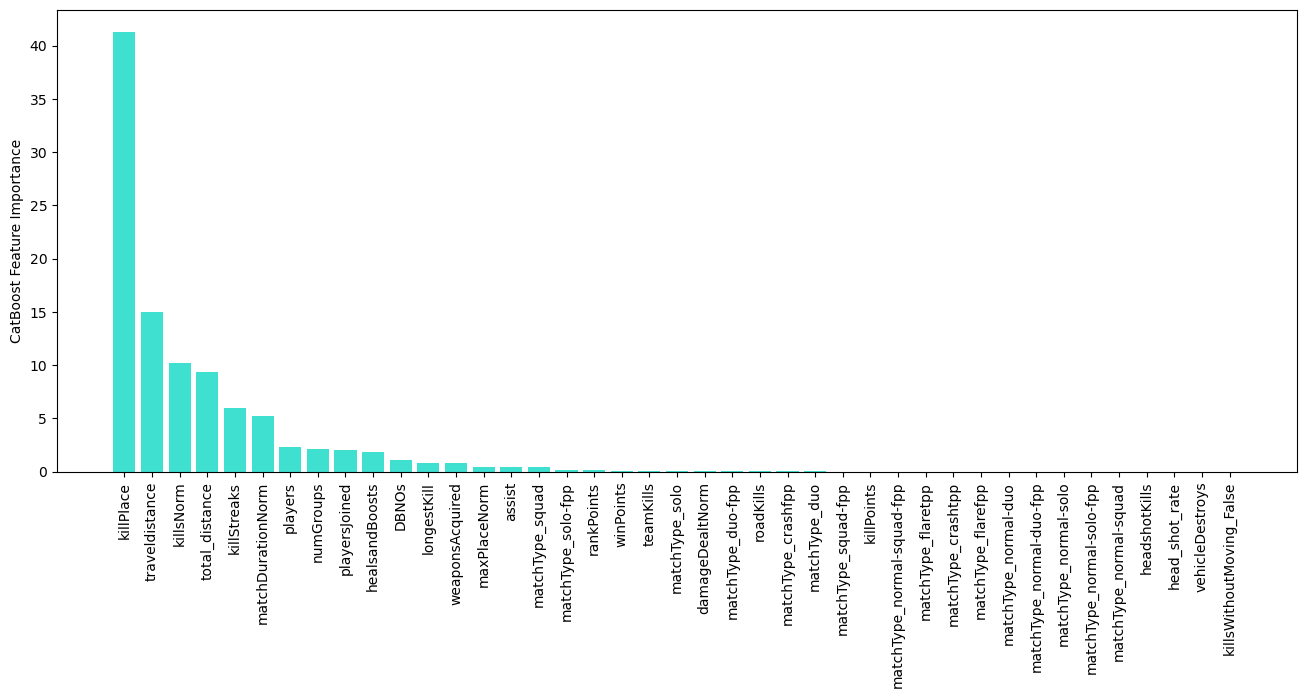

In [132]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

## Prediction

In [133]:
pred = model.predict(x_test)

In [134]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93


<center><img src = "https://media.giphy.com/media/KB89dMAtH79VIvxNCW/giphy.gif"></center>